In [1]:
from astropy.io import fits, ascii
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import patches as mpatch
from astropy import units as u
from astropy.visualization import simple_norm, ZScaleInterval, PercentileInterval, ImageNormalize, SinhStretch, LogStretch, SquaredStretch
from reproject import reproject_interp
import astrodendro
import os
from spectral_cube import SpectralCube 
from astropy import wcs
from astropy.wcs import WCS  
from regions import Regions
from regions import PixCoord, RectanglePixelRegion
from matplotlib.patches import Ellipse
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astrodendro.pruning import contains_seeds
from astropy.table import Table, hstack, Column
from astropy.coordinates import SkyCoord
from regions import Region, RectanglePixelRegion, RectangleSkyRegion, Regions
from matplotlib.patches import Rectangle
from astropy.convolution import convolve_fft, Gaussian2DKernel
from collections import Counter
from astropy.nddata.utils import Cutout2D
from regions import PixCoord

%matplotlib inline
%config Completer.use_jedi = False

params = {
    ## ********************************************************************************
    ## * General Settings
    ## ********************************************************************************
    'image.cmap': 'Purples_r',#'bone_r', 			#Change the colormap for images when using imshow
    'savefig.dpi': 1390,  			#to adjust notebook inline plot size
    'text.usetex': False,            		#Use LaTeX to render. Allows you to use LaTeX for the figure text (axes, labels, etc.), but increases render time. 
    								#I usually disable LaTeX for making plots quickly in Jupyter, as otherwise it takes rather long to display. You must have LaTeX on your computer for this to work!
    'font.family': 'sans-serif',			#Options: serif, sans-serif, cursive, fantasy, monospace 
    #'figure.autolayout': True,      		#This applies 'tight_layout' to the plot to make the plot fit the fig, useful when saving plots
    
    ## ********************************************************************************
    ## * Axes Settings
    ## ********************************************************************************
    'axes.linewidth': 1,			#Makes the plot edges thicker, is 0.8 by default
    'axes.grid': False,				#display grid or not
    #'axes.grid.which': 'major',			#gridlines at {major, minor, both} ticks
    'axes.labelsize': 12, 			#fontsize for x and y labels
    'font.size': 14, 				#fontsize for annotations etc.
    'legend.fontsize': 8, 			#fontsizez for legend text
    #'legend.frameon': False, 			#removes the border around the legend box when set to 'False'
    #'legend.markerscale': 1.0, 			#the relative size of legend markers vs. original
    
    ## ********************************************************************************
    ## * x-axis settings
    ## ********************************************************************************
    'xtick.labelsize': 12, 			#fontsize of the x-tick labels
    'xtick.major.size': 5,			#length of major x-tick
    'xtick.major.width': 1,			#width of major x-tick
    #'xtick.minor.size': 5,			#length of minor x-tick
    #'xtick.minor.width': 1,			#width of minor x-tick
    'xtick.major.top'    : True ,   		#draw x axis top major ticks
    'xtick.major.bottom' : True ,   		#draw x axis bottom major ticks
    #'xtick.minor.top'     : True,   		#draw x axis top minor ticks
    #'xtick.minor.bottom' : True ,   		#draw x axis bottom minor ticks
    'xtick.direction': 'in',			#direction x-ticks point
    #'xtick.minor.visible' : True,   		#Quick toggle minor x-ticks on/off

    ## ********************************************************************************
    ## * y-axis settings
    ## ********************************************************************************    
    'ytick.labelsize': 12, 			#fontsize of the y-tick labels
    'ytick.major.size': 5,			#length of major y-tick
    'ytick.major.width': 1,			#width of major y-tick
    #'ytick.minor.size': 5,			#length of minor y-tick
    #'ytick.minor.width': 1,			#width of minor y-tick
    'ytick.major.left'    : True ,  		#draw y-axis left major ticks
    'ytick.major.right' : True ,   		#draw y-axis right major ticks
    #'ytick.minor.left'     : True,  		#draw y-axis left minor ticks
    #'ytick.minor.right' : True ,   		#draw y-axis right minor ticks
    'ytick.direction': 'in',			#direction y-ticks point
    #'ytick.minor.visible' : True,   		#Quick toggle minor y-ticks on/off
}
matplotlib.rcParams.update(params)

In [2]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax_histx.hist(x, color='purple', bins=27)
    ax_histy.hist(y, bins=10, orientation='horizontal', color='purple') #bins=bins,

def is_coordinate_in_3d_range(point, min_corner, max_corner):
    """
    Checks if a 3D coordinate is within a specified 3D range.

    Args:
        point (tuple): A tuple (x, y, z) representing the 3D coordinate.
        min_corner (tuple): A tuple (min_x, min_y, min_z) representing the minimum corner of the range.
        max_corner (tuple): A tuple (max_x, max_y, max_z) representing the maximum corner of the range.

    Returns:
        bool: True if the point is within the range, False otherwise.
    """
    x, y, z = point
    min_x, min_y, min_z = min_corner
    max_x, max_y, max_z = max_corner

    return (min_x <= x <= max_x and
            min_y <= y <= max_y and
            min_z <= z <= max_z)

In [3]:
basepath = '/home/j_poz/documents/milkywaylab/data'

hdu_lb = fits.open(f'{basepath}/images/CS21_CubeMosaic_max.fits')[0] 
hdu_data_lb = hdu_lb.data
header_lb = hdu_lb.header
wcs_lb = WCS(header_lb)

hdu_lv = fits.open(f'{basepath}/images/CS21_CubeMosaic_PV_max.fits')[0] 
hdu_data_lv = hdu_lv.data
header_lv = hdu_lv.header
wcs_lv = WCS(header_lv)

# Grab the CS data cube:
file= basepath+ '/images/CS21_CubeMosaic_downsampled9.fits'
cube = SpectralCube.read(file)
sub_cube= cube       #can add .subcube(xlo=?*u.deg, xhi=?*u.deg, etc) to work with a smaller subcube  
wcs = sub_cube.wcs
sub_cube.allow_huge_operations=True
lowres_max = sub_cube.max(axis=0)
# Calculate the beam area in deg^2 (gaussian area)
beam_omega_deg2 = (sub_cube.header['BMAJ']*sub_cube.header['BMIN']*np.pi)/(4*np.log(2))

# Convert beam parameters to get # of pixels in beam:
pix_area_deg2 = abs(sub_cube.header['CDELT1']) * abs(sub_cube.header['CDELT2'])
mpix = beam_omega_deg2/pix_area_deg2

/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/spectral_cube.py:534: RuntimeWarning: All-NaN slice encountered
  result = function(np.dstack((result, plane)), axis=2, **kwargs)


In [4]:
cat_file = basepath+'/tables/CS_HVCC_fullcatalog_mv_15_ms_10_mp_2.797753174325516.fits'
cat = Table.read(cat_file)

# Create a mask that removes sources based on verticality, l extent and v extent:
cat_mask = (((cat['lmax_pix']-cat['lmin_pix'])>=2.) 
            & (cat['verticality'] >= 1000000)
            & ((cat['lmax_pix']-cat['lmin_pix'])<50.)
            & (np.abs(cat['del_v'] > 10000)))

cat = cat[cat_mask]

dend = astrodendro.Dendrogram.load_from(basepath+'/images/dendrogram.fits')

In [4]:
# Grab the EVF by-eye ID table:
tbl = Table(ascii.read(basepath+'/tables/HVCC_resampled_again.ecsv', format='ecsv'))
# Get EVF coords in pixels:
center_sky = SkyCoord(tbl['l']*u.deg, tbl['b']*u.deg, frame = 'galactic')

tbl['vert'] = np.divide(np.abs(tbl['deltaV']), np.abs(tbl['deltal'])) 
tbl['x_pix'], tbl['y_pix'] = center_sky.to_pixel(wcs)
tbl['v_pix'] =(((tbl['V_LSR'].data- sub_cube.header['CRVAL3'])/(sub_cube.header['CDELT3'] )) + sub_cube.header['CRPIX3'] )#.astype(int)

# Currently rounding values and not using int:
#tbl['x_pix'] = [round(item) for item in tbl['x_pix']]
#tbl['y_pix'] = [round(item) for item in tbl['y_pix']]
#tbl['v_pix'] = [round(item) for item in tbl['v_pix']]


norm = ImageNormalize(hdu_data_lb, interval=PercentileInterval(99.7))

In [7]:
np.where(np.isnan(tbl['dendro_match'][:163]))

(array([  4,  10,  11,  19,  21,  32,  35,  60,  64,  83,  85,  88,  90,
         91,  97,  98,  99, 100, 106, 108, 110, 121, 125]),)

In [6]:
d = []

for c, coord in enumerate(tbl['l']):
    pix_coords = (tbl['x_pix'][c], tbl['y_pix'][c], tbl['v_pix'][c])

    x=[]
    area= []
    for s, struc in enumerate(cat['idx']):
        cond = is_coordinate_in_3d_range(pix_coords,
                                        (cat['lmin_pix'][s], cat['bmin_pix'][s],  cat['vmin_pix'][s]), 
                                         (cat['lmax_pix'][s], cat['bmax_pix'][s], cat['vmax_pix'][s])) 
        if cond == True:
       
            x.append(struc)
            #num.append(struc.get_npix())
            area.append(cat['area_exact'][s])
        
    if x == []:
        d.append(np.nan)
    else:
        x = np.array(x)
        area = np.array(area)
        max_x = x[area == np.nanmax(area)]
        
        d.extend(x)#append(max_x[0]) #Use append(max_x[0] instead if you just want the largest structure containing the given coordinate

d = np.array(d)
cat.add_index('idx')

cat = cat.loc[np.unique(d[~np.isnan(d)])]

In [7]:
# Save mask so you it can be plotted elsewhere:

#tot_struc = []
mask2d_lv = np.zeros(sub_cube[:,0,:].shape)
mask2d = np.zeros(sub_cube[0,:,:].shape)
mask3d = np.zeros(sub_cube.shape)
#mask.fill(np.nan)
for s, struc in enumerate(dend.all_structures):
    if struc.idx not in cat['idx']:
        continue
    else:
    #if struc.idx == 179:
        evf_mask = struc.get_mask()
        ind, val = struc.get_peak()
        #print(ind)
        #print(np.where(evf_mask==True))
        #for v in range(0,len(sub_cube.shape[0]):
        #    print(v)
        lb_mask = evf_mask[ind[0],:,:]
        lv_mask = evf_mask[:,ind[1], :]
        #tot_struc.append(struc.idx)
        #mask2d[(lb_mask==True)] = 1.0 #(struc.idx)
        #mask3d[(evf_mask==True)] = (struc.idx)
        #mask_size = []
        #vel = []
        #for v in range(np.nanmin(struc.indices()[0]), np.nanmax(struc.indices()[0])+1):
        #    lb_mask = evf_mask[v,:,:]
        #    mask_size.append(len(np.where(lb_mask == True)[0])*len(np.where(lb_mask == True)[1]))
        #    vel.append(v)
        #vel_slice = vel[int(np.where(mask_size==np.nanmax(mask_size))[0][0])]
        #lbmax_mask = evf_mask[vel_slice,:,:]
        #mask2d[(lbmax_mask==True)] = 1.0 #(struc.idx)
        mask2d[(lb_mask==True)] = 1.0
        mask2d_lv[(lv_mask==True)] = 1.0
    

In [8]:
# Save mask so you it can be plotted elsewhere:
mask2d_hdu = fits.PrimaryHDU(mask2d, header=sub_cube[0,:,:].header)
#mask2d_hdu.writeto(dir+'EVF_sprint_2025/CS_HVCC_2d_mask.fits', overwrite=True)

#mask3d_hdu = fits.PrimaryHDU(mask2d, header=sub_cube.header)
#mask3d_hdu.writeto(dir+'EVF_sprint_2025/CS_HVCC_3d_mask.fits', overwrite=True)
mask2d_lv_hdu = fits.PrimaryHDU(mask2d_lv, header=sub_cube[:,0,:].header)


In [9]:
array, footprint = reproject_interp(mask2d_hdu, header_lb)
mask_lv, footprint = reproject_interp(mask2d_lv_hdu, header_lv)

In [10]:
l_peaks = []
for i, index in enumerate(cat['idx'].value): 

    if cat['l_peak'][i] > 180:
        l_peak = cat['l_peak'][i] - 360
    else:
        l_peak = cat['l_peak'][i]
    l_peaks.append(l_peak)

cat['l_peak'] = l_peaks

filtered_table = cat

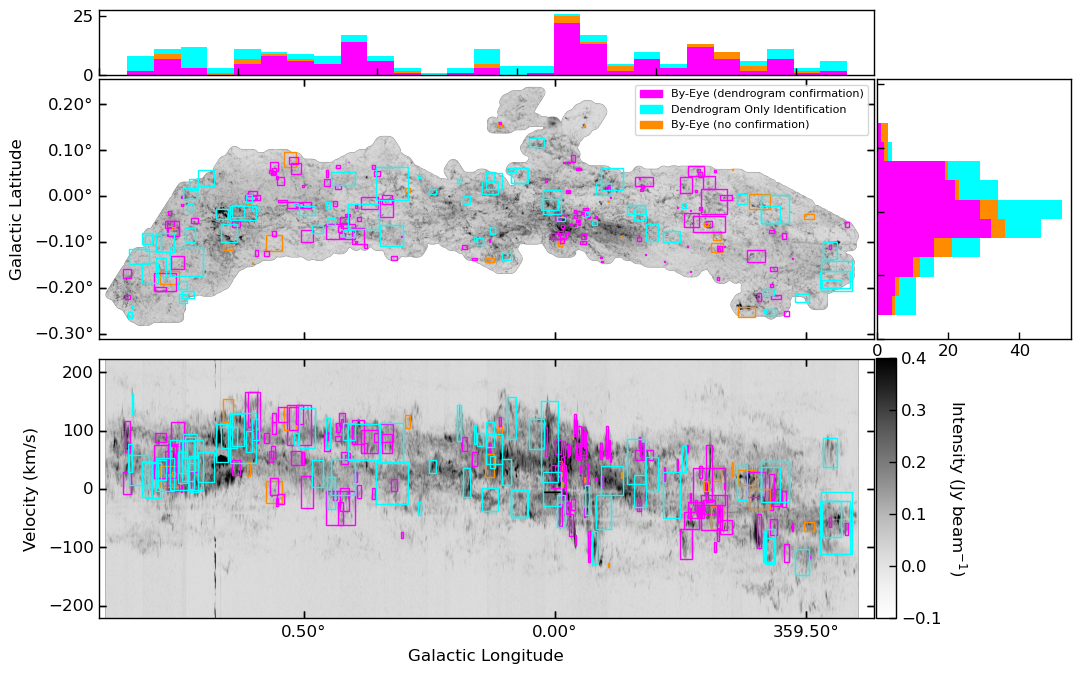

In [14]:
# Plot dendrogram masks & evf extents
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(211, projection=wcs_lb)
ax2 = fig1.add_subplot(212, projection=wcs_lv)

plt.subplots_adjust(hspace=0.075)

lon2 = ax2.coords['glon']
lon1 = ax1.coords['glon']

ax1.coords['glon'].set_ticklabel_visible(False)
lat1 = ax1.coords['glat']
velax = ax2.coords['vrad']
velax.set_format_unit(u.km/u.s)
lon2.set_major_formatter('d.dd')
lon1.set_major_formatter('d.dd')
lat1.set_major_formatter('d.dd')
ax1.set_ylabel('Galactic Latitude')
ax1.set_xlabel('Galactic Longitude')
ax2.set_xlabel('Galactic Longitude')
ax2.set_ylabel('Velocity (km s$^-1$)')

ax_histx = ax1.inset_axes([0, 1.015, 1, 0.25], sharex=ax1)
ax_histy = ax1.inset_axes([1.005, 0, 0.25, 1], sharey=ax1)



im1 = ax1.imshow(hdu_data_lb, cmap='Greys',  origin = 'lower', vmin = -0.1, vmax = 0.4, aspect='auto') 
#ax1.contour(array, levels= [0.99], origin='lower', linewidths=[0.4], colors='cyan')


tbl['deltal'] = abs(tbl['deltal'])
tbl['deltab'] = abs(tbl['deltab'])


# Plot by-eye IDed EVFs:
reg_list = []
x_scatter_be_dendro=[]
x_scatter_be_no_dendro=[]
x_scatter_d= []

y_scatter_be_dendro=[]
y_scatter_be_no_dendro=[]
y_scatter_d=[]

for evf in tbl[:163]:
    center_sky = SkyCoord(evf['l'], evf['b'], unit = 'deg', frame = 'galactic')
    reg = RectangleSkyRegion(center_sky, width = evf['deltal']*u.deg, height = evf['deltab']*u.deg)
    pixel_region = reg.to_pixel(wcs_lb)
    
    reg_list.append(pixel_region)
    xs, ys = wcs_lb.wcs_world2pix(center_sky.l, center_sky.b, 1)
    
    if np.isnan(evf['dendro_match']):
        x_scatter_be_no_dendro.append(xs)
        y_scatter_be_no_dendro.append(ys)
        continue
        
    x_scatter_be_dendro.append(xs)
    y_scatter_be_dendro.append(ys)

for evf in tbl[163:]:
    center_sky = SkyCoord(evf['l'], evf['b'], unit = 'deg', frame = 'galactic')
    reg = RectangleSkyRegion(center_sky, width = evf['deltal']*u.deg, height = evf['deltab']*u.deg)
    pixel_region = reg.to_pixel(wcs_lb)
    
    reg_list.append(pixel_region)
    xs, ys = wcs_lb.wcs_world2pix(center_sky.l, center_sky.b, 1)
    x_scatter_d.append(xs)
    y_scatter_d.append(ys)
        
for i, evf in enumerate(reg_list):
    if np.isnan(tbl['dendro_match'][i]) and i < 163:
        color='darkorange'
    elif i<=163:
        color='fuchsia'
    else:
        color='cyan'
    evf.plot(ax=ax1, color=color, linewidth=1)

ax1.legend(handles=[mpatch.Patch(color='fuchsia', label='By-Eye (dendrogram confirmation)'), 
                    mpatch.Patch(color='cyan', label='Dendrogram Only Identification'), 
                    mpatch.Patch(color='darkorange', label='By-Eye (no confirmation)') ])
#plt.colorbar(im1, ax = ax1, label = 'Intensity', pad=0)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax_histx.hist([x_scatter_be_dendro, x_scatter_be_no_dendro, x_scatter_d], color=['fuchsia', 'darkorange', 'cyan'], bins=27, stacked=True)
ax_histy.hist([y_scatter_be_dendro, y_scatter_be_no_dendro, y_scatter_d], bins=10, color=['fuchsia', 'darkorange', 'cyan'], 
              orientation='horizontal', stacked=True)

im2 = ax2.imshow(hdu_data_lv, cmap='Greys', vmin = -0.1, vmax = 0.4, aspect= 'auto')
#ax2.contour(mask_lv, levels= [0.99], origin='lower', linewidths=[0.4], colors='cyan')

# Plot by-eye EVF extents
tbl['l_max'], tbl['v_max'] = wcs_lv.world_to_pixel_values(tbl['l']+(tbl['deltal']/2), (tbl['max_v']*u.km/u.s).to(u.m/u.s))
tbl['l_min'], tbl['v_min'] = wcs_lv.world_to_pixel_values(tbl['l']-(tbl['deltal']/2), (tbl['min_v']*u.km/u.s).to(u.m/u.s))
for i, index in enumerate(tbl['ID Number']):
    if np.isnan(tbl['dendro_match'][i]) and i < 163:
        color='darkorange'
    elif i<=163:
        color='fuchsia'
    else:
        color='cyan'
    ax2.add_patch(Rectangle((tbl['l_min'][i], tbl['v_min'][i]), tbl['l_max'][i]-tbl['l_min'][i], tbl['v_max'][i]-tbl['v_min'][i], 
                            edgecolor=color, facecolor='None',linestyle='-'))
    
cax = fig1.add_axes([.9025, 0.11, 0.02, 0.3725])# sharey=ax2) 
cb = plt.colorbar(im2, cax = cax)
cb.set_label(label = r'Intensity (Jy beam$^{-1}$)',rotation=270,labelpad=20)

plt.savefig(f'{basepath}/figs/ACES_CS_HVCC_lb_lv_plot_dendro.pdf', bbox_inches='tight')
plt.show()

In [45]:
# WIP for zoom-in panels:
#Sag A* = (6600, 2000), Sag B2 = (1700,200), East Clump = ()
lb1_center = [(1700,2000), (8500, 2000), (6500, 2000)] #(l,b)
lb1_size = [(2000, 1500), (2000, 1500), (1500, 1250)] # (bdelt,ldelt)
lv1_center = [(1700, 180), (8500,130), (6500, 150)] #(l,v)
lv1_size = [(180, 1500), (200,1500), (225,1500)] #(vdelt, ldelt)

lb_cut1 = Cutout2D(hdu_data_lb, lb1_center[0], lb1_size[0], wcs=wcs_lb)
lv_cut1 = Cutout2D(hdu_data_lv, lv1_center[0], lv1_size[0], wcs=wcs_lv)

lb_cutout_mask, footprint = reproject_interp(mask2d_hdu, lb_cut1.wcs)
lv_cutout_mask, footprint = reproject_interp(mask2d_lv_hdu, lv_cut1.wcs)

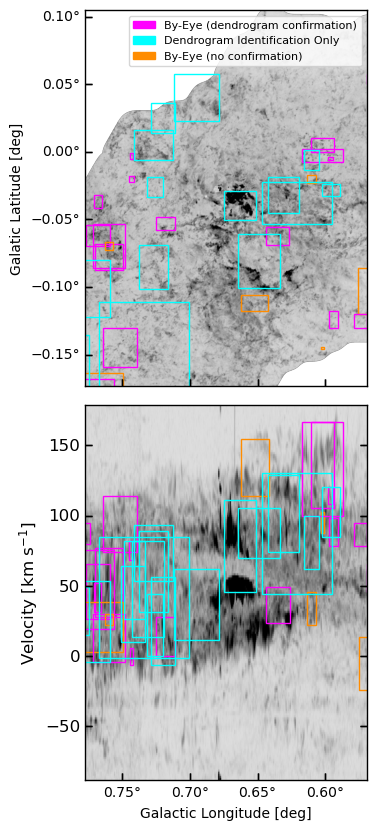

In [46]:
# Plot zoom in panel
tbl['l_max'], tbl['v_max'] = lv_cut1.wcs.world_to_pixel_values(tbl['l']+(tbl['deltal']/2), (tbl['max_v']*u.km/u.s).to(u.m/u.s))
tbl['l_min'], tbl['v_min'] = lv_cut1.wcs.world_to_pixel_values(tbl['l']-(tbl['deltal']/2), (tbl['min_v']*u.km/u.s).to(u.m/u.s))

fig1 = plt.figure(figsize=(4, 10))
ax1 = fig1.add_subplot(211, projection=lb_cut1.wcs)
ax2 = fig1.add_subplot(212, projection=lv_cut1.wcs)
reg_list=[]

for i, evf in enumerate(tbl):
    center_sky = SkyCoord(evf['l'], evf['b'], unit = 'deg', frame = 'galactic')
    reg = RectangleSkyRegion(center_sky, width = evf['deltal']*u.deg, height = evf['deltab']*u.deg)
    pixel_region = reg.to_pixel(lb_cut1.wcs)
    reg_list.append(pixel_region)
    
im1=ax1.imshow(lb_cut1.data, cmap='Greys', vmin = -0.1, vmax = 0.4)#, aspect=3)
ax1.set_ylabel('Galactic Latitude')
ax1.coords[0].set_ticklabel_visible(False)
ax1.coords[0].set_axislabel('')
for i, reg in enumerate(reg_list):
    if np.isnan(tbl['dendro_match'][i]) and i <= 163:
        color='darkorange'
    elif i <= 163:
        color='fuchsia'
    else: 
        color='cyan'
    reg.plot(ax=ax1, color=color, linewidth=1)

lon = ax1.coords[0]
lat = ax1.coords[1]

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.set_ylabel('Galatic Latitude [deg]', fontsize=10)
ax1.set_xlabel('Galactic Longitude [deg]', fontsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')

ax1.legend(handles=[mpatch.Patch(color='fuchsia', label='By-Eye (dendrogram confirmation)'), 
                    mpatch.Patch(color='cyan', label='Dendrogram Identification Only'), 
                    mpatch.Patch(color='darkorange', label='By-Eye (no confirmation)') ])

#ax1.set_aspect(.7)

im2=ax2.imshow(lv_cut1.data, cmap='Greys', aspect='auto', vmin = -0.1, vmax = 0.4)

for i, evf in enumerate(tbl):
    if np.isnan(tbl['dendro_match'][i]) and i <= 163:
        color='darkorange'
    elif i <= 163:
        color='fuchsia'
    else: 
        color='cyan'
    ax2.add_patch(Rectangle((evf['l_min'], evf['v_min']), evf['l_max']-evf['l_min'], evf['v_max']-evf['v_min'], 
                            edgecolor=color, facecolor='None',linestyle='-'))

ax2.set_ylabel('Velocity [km s$^{-1}$]')

lon = ax2.coords[0]
lon.set_major_formatter('d.dd')
ax2.set_xlabel('Galactic Longitude [deg]', fontsize=10)
ax2.tick_params(axis='x', labelsize=10)
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')

velax = ax2.coords['vrad']
velax.set_format_unit(u.km/u.s)

ax2.set_aspect(11.1)

plt.subplots_adjust(hspace=0.05)

plt.show()

In [49]:
lv_regs

[<RectanglePixelRegion(center=PixCoord(x=8500, y=130), width=1500, height=200, angle=0.0 deg)>,
 <RectanglePixelRegion(center=PixCoord(x=1700, y=150), width=1500, height=200, angle=0.0 deg)>,
 <RectanglePixelRegion(center=PixCoord(x=6500, y=2000), width=1500, height=200, angle=0.0 deg)>]

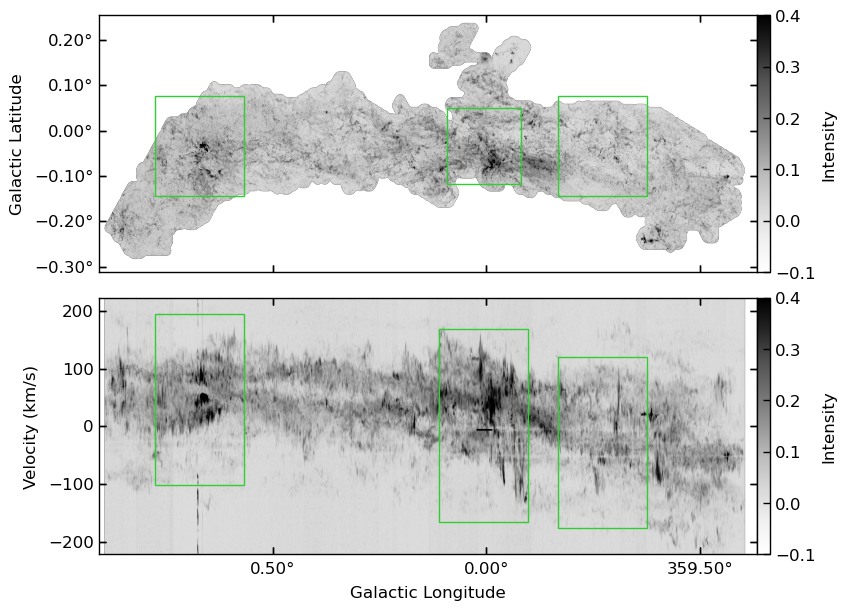

In [72]:
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(211, projection=wcs_lb)
ax2 = fig1.add_subplot(212, projection=wcs_lv)

lon1 = ax1.coords['glon']
lon2 = ax2.coords['glon']

ax1.coords['glon'].set_ticklabel_visible(False)
lat1 = ax1.coords['glat']
velax = ax2.coords['vrad']
velax.set_format_unit(u.km/u.s)
lon2.set_major_formatter('d.dd')
lon1.set_major_formatter('d.dd')
lat1.set_major_formatter('d.dd')
ax1.set_ylabel('Galactic Latitude')
ax1.set_xlabel('Galactic Longitude')
ax2.set_xlabel('Galactic Longitude')
ax2.set_ylabel('Velocity (km/s)')

im1 = ax1.imshow(hdu_data_lb, cmap='Greys',  origin = 'lower', vmin = -0.1, vmax = 0.4, aspect='auto') 

plt.colorbar(im1, ax = ax1, label = 'Intensity', pad=0)

lb_regs = []
for i, reg in enumerate(lb1_center):
    pix_coord = PixCoord(reg[0], reg[1])
    pix_reg = RectanglePixelRegion(pix_coord, lb1_size[i][1], lb1_size[i][0]*0.8)
    lb_regs.append(pix_reg)
for reg in lb_regs:
    reg.plot(ax=ax1, color='limegreen', linewidth=1)

im2 = ax2.imshow(hdu_data_lv, cmap='Greys', vmin = -0.1, vmax = 0.4, aspect= 'auto')

plt.colorbar(im2, ax = ax2, label = 'Intensity', pad=0)

lv_regs = []
for i, reg in enumerate(lv1_center):
    pix_coord = PixCoord(reg[0], reg[1])
    pix_reg = RectanglePixelRegion(pix_coord, lv1_size[i][1], lv1_size[i][0])
    lv_regs.append(pix_reg)
for reg in lv_regs:
    reg.plot(ax=ax2, color='limegreen', linewidth=1)

plt.subplots_adjust(hspace=0.1)

plt.show()

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8,4),subplot_kw=dict(projection=wcs_lv))#projection=wcs, slices=('x', 'y', 50)))#fig1.add_subplot(gs[0, :], projection=wcs_lb)

#ax.contour(mask, levels=[-1], colors='white')


im1 = ax1.imshow(hdu_data_lv, cmap='Greys', vmin = -0.1, vmax = 0.25, aspect= 'auto')
ax1.contour(mask_lv, levels= [0.99], origin='lower', linewidths=[0.4], colors='cyan')

# Plot dendrogram EVF extents
#filtered_table['lmax_pix'], filtered_table['vmax_pix'] = wcs_lv.world_to_pixel_values(filtered_table['lmax_u'], filtered_table['vmax_u'])
#filtered_table['lmin_pix'], filtered_table['vmin_pix'] = wcs_lv.world_to_pixel_values(filtered_table['lmin_u'], filtered_table['vmin_u'])
#for i, index in enumerate(filtered_table['idx']):
    
#    ax1.add_patch(Rectangle((filtered_table['lmin_pix'][i], filtered_table['vmin_pix'][i]), 
#                            filtered_table['lmax_pix'][i]-filtered_table['lmin_pix'][i], 
#                            filtered_table['vmax_pix'][i]-filtered_table['vmin_pix'][i], 
#                            edgecolor='white', facecolor='None',linestyle='-'))

# Plot by-eye EVF extents
tbl['l_max'], tbl['v_max'] = wcs_lv.world_to_pixel_values(tbl['l']+(tbl['deltal']/2), tbl['max_v'].to(u.m/u.s))
tbl['l_min'], tbl['v_min'] = wcs_lv.world_to_pixel_values(tbl['l']-(tbl['deltal']/2), tbl['min_v'].to(u.m/u.s))
for i, index in enumerate(tbl['ID Number']):
    
    ax1.add_patch(Rectangle((tbl['l_min'][i], tbl['v_min'][i]), 
                            tbl['l_max'][i]-tbl['l_min'][i], 
                            tbl['v_max'][i]-tbl['v_min'][i], 
                            edgecolor='red', facecolor='None',linestyle='-'))

lon1 = ax1.coords['glon']
velax = ax1.coords['vrad']
lon1.set_major_formatter('d.dd')
velax.set_format_unit(u.km/u.s)

ax1.set_ylabel('Velocity (km/s)')
ax1.set_xlabel('Galactic Longitude')
cb = plt.colorbar(im1, ax = ax1, pad=0)
cb.set_label(label = r'Intensity (Jy beam$^{-1}$)',rotation=270,labelpad=20)
ax1.set_xlim(50, 10900) #11120
#print(np.nanmin(hdu_data_lv[1]), np.nanmax(hdu_data_lv[1]))

plt.savefig(dir+'EVF_sprint_2025/ACES_CS_HVCC_lvplot.pdf', bbox_inches='tight')
plt.show()